In [1]:
%config IPCompleter.greedy=True;

In [2]:
"""
TODOs:
"""

'\nTODOs:\n'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, cross_val_score
import numpy as np
from timeit import default_timer as timer

In [4]:
dataFile = "../data/beijing_pm25.csv"

In [5]:
# Read data file.
df = pd.read_csv(dataFile,sep=',')
originalCount = df.shape[0]
# Drop rows with NaN values in target column pm2.5
sizeBefore = df.shape[0]
df = df.dropna()
nanCount = sizeBefore - df.shape[0]
print(f"Initial dataset with {df.shape[0]} rows (originally {originalCount}) and {df.shape[1]} columns, dropped {nanCount} NaN rows")

Initial dataset with 41757 rows (originally 43824) and 13 columns, dropped 2067 NaN rows


In [6]:
# Add week days column
dates = pd.to_datetime(df[["day", "month","year", "hour"]])
week_days = [d.isoweekday() for d in dates]
df["week_day"] = week_days

In [7]:
# Drop No column which is just ID and reorganize columns 
df = df[["week_day","day", "month", "year", "hour", "DEWP", "TEMP", "PRES", "cbwd", "Iws", "Is", "Ir", "pm2.5"]]
# Rename columns to sensible names
df = df.rename({
    "DEWP": "dew_point", 
    "TEMP": "temperature", 
    "PRES": "pressure",
    "cbwd": "wind_direction",
    "Iws": "wind_speed",
    "Is": "hours_snow",
    "Ir": "hours_rain"}, axis=1)

In [8]:
# Columns statistics
df.describe()

,week_day,day,month,year,hour,dew_point,temperature,pressure,wind_speed,hours_snow,hours_rain,pm2.5
count,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000
mean,4.001892,15.685514,6.513758,2012.042771,11.502311,1.750174,12.401561,1016.442896,23.866747,0.055344,0.194866,98.613215
std,1.994789,8.785539,3.454199,1.415311,6.924848,14.433658,12.175215,10.300733,49.617495,0.778875,1.418165,92.050387
min,1.000000,1.000000,1.000000,2010.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000,0.000000
25%,2.000000,8.000000,4.000000,2011.000000,5.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000,29.000000
50%,4.000000,16.000000,7.000000,2012.000000,12.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000,72.000000
75%,6.000000,23.000000,10.000000,2013.000000,18.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000,137.000000
max,7.000000,31.000000,12.000000,2014.000000,23.000000,28.000000,42.000000,1046.000000,565.490000,27.000000,36.000000,994.000000


In [9]:
def boxplot_for_group(groupColumns, plotTitle, showOutliers=False, pdfFile=None):
    bpData = []
    xTics = []
    for (name, group) in df.groupby(groupColumns):
        xTics.append(name)
        bpData.append(group["pm2.5"])

    # Multiple box plots on one Axes
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_title(plotTitle)

    ax.boxplot(bpData, showfliers=showOutliers)
    ax.set_xticklabels(xTics)

    if pdfFile != None:
        plt.savefig(pdfFile)
    else:
        plt.show()

In [10]:
def boxplot_for_year_group(groupColumns, plotTitle, showOutliers=False, pdfFile=None):
    
    fig, axs = plt.subplots(5, figsize=(20,20),sharey=True)
    #ax1.plot(x, y)
    #ax2.plot(x, -y)
    index=0
    
    for (yName,yGroup) in df.groupby(["year"]):
        bpData = []
        xTics = []
        for (name, group) in yGroup.groupby(groupColumns):
            xTics.append(name)
            bpData.append(group["pm2.5"])

        #fig, ax = plt.subplots(figsize=(15,5))
        axs[index].set_title(yName)
        axs[index].boxplot(bpData, showfliers=showOutliers)
        axs[index].set_xticklabels(xTics)
        index += 1
        
    #axs.tight_layout()
    fig.tight_layout()

    if pdfFile != None:
        plt.savefig(pdfFile)
    else:
        plt.show()

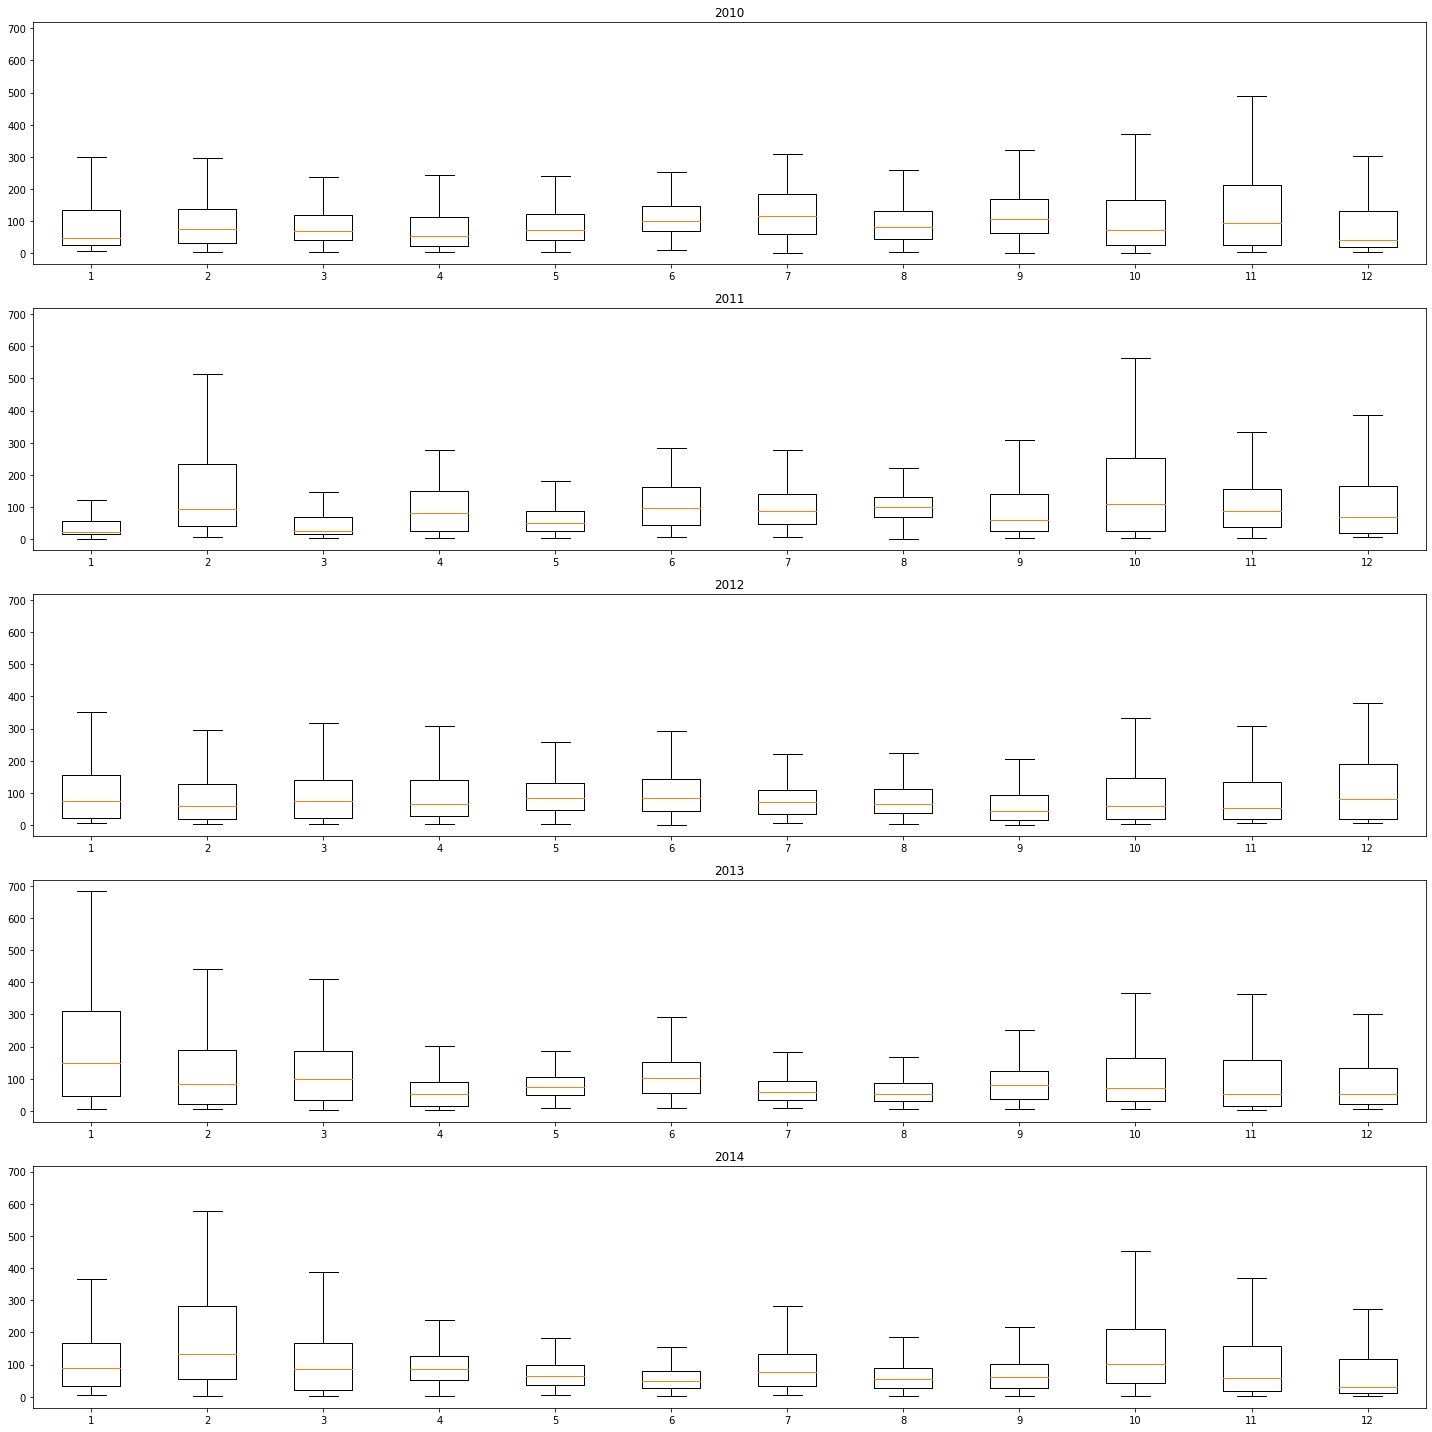

In [11]:
#boxplot_for_group(["year"],"Koncentrace PM2.5 podle roku", showOutliers=False, pdfFile="target_by_year.pdf")
#boxplot_for_group(["hour"],"Koncentrace PM2.5 podle hodiny", showOutliers=False, pdfFile="target_by_hour.pdf")
boxplot_for_year_group(["month"], "Koncentrace PM2.5 podle mesicu v rocich", showOutliers=False, pdfFile="target_by_month_by_year.pdf")

In [12]:
# Week day analysis
weekDaysDf = pd.DataFrame(df["week_day"].value_counts())
weekDaysDf = weekDaysDf.sort_index()
weekDaysDf
# df["week_day"].hist(bins=7)

,week_day
1,5923
2,5932
3,5989
4,6011
5,6019
6,5967
7,5916


<BarContainer object of 7 artists>

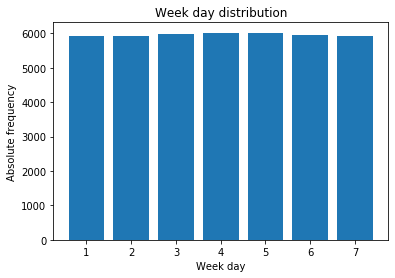

In [13]:
plt.title("Week day distribution")
plt.xlabel("Week day")
plt.ylabel("Absolute frequency")
plt.bar(weekDaysDf.index.values, weekDaysDf.week_day.values)

In [14]:
# Month analysis
monthDf = pd.DataFrame(df["month"].value_counts())
monthDf = monthDf.sort_index()
monthDf

,month
1,3471
2,3373
3,3556
4,3405
5,3609
6,3405
7,3647
8,3337
9,3333
10,3579


<BarContainer object of 12 artists>

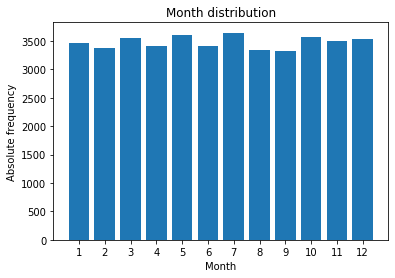

In [15]:
plt.title("Month distribution")
plt.xlabel("Month")
plt.ylabel("Absolute frequency")
plt.xticks(monthDf.index.values)
plt.bar(monthDf.index.values, monthDf.month.values)

In [16]:
# Year analysis
yearDf = pd.DataFrame(df["year"].value_counts())
yearDf = yearDf.sort_index()
yearDf

,year
2010,8091
2011,8032
2012,8295
2013,8678
2014,8661


<BarContainer object of 5 artists>

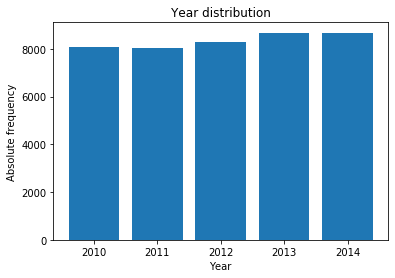

In [17]:
plt.title("Year distribution")
plt.xlabel("Year")
plt.ylabel("Absolute frequency")
plt.xticks(yearDf.index.values)
plt.bar(yearDf.index.values, yearDf.year.values)

In [18]:
# Wind direction analysis
#set(df["wind_direction"])
windDirDf = pd.DataFrame(df["wind_direction"].value_counts())
windDirDf = windDirDf.sort_index()
windDirDf

,wind_direction
NE,4756
NW,13484
SE,14573
cv,8944


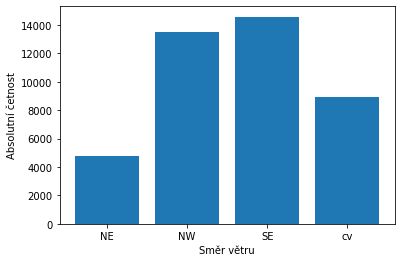

In [19]:
# plt.title("Absolut")
plt.xlabel("Směr větru")
plt.ylabel("Absolutní četnost")
#plt.set_xticklabels(["a","b","c","d"])
plt.bar(windDirDf.index.values,windDirDf.wind_direction.values)
plt.savefig("wind_dir_dist.pdf")

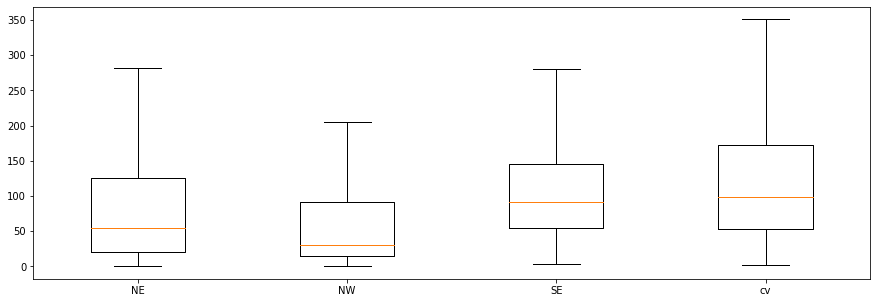

In [20]:
boxplot_for_group(["wind_direction"], "", pdfFile="target_by_wind_dir.pdf")

In [21]:
def outlier_count(boxplot_object):    
    assert len(boxplot_object["fliers"]) == 1
    yData =  boxplot_object["fliers"][0].get_ydata()
    outlierCount = len(yData)
    return outlierCount

dew_point outlier count 0 out of 41757
temperature outlier count 0 out of 41757
pressure outlier count 0 out of 41757
wind_speed outlier count 4893 out of 41757
hours_snow outlier count 368 out of 41757
hours_rain outlier count 1739 out of 41757
pm2.5 outlier count 1773 out of 41757


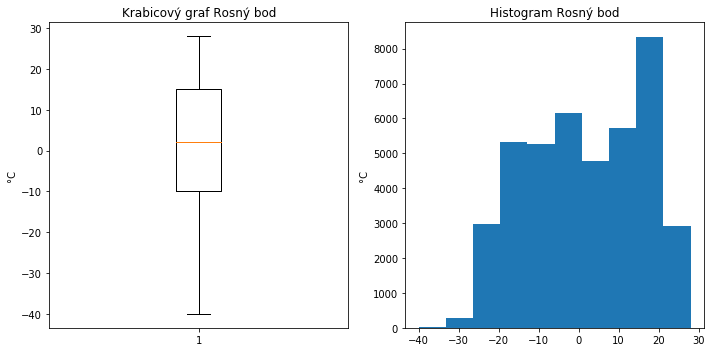

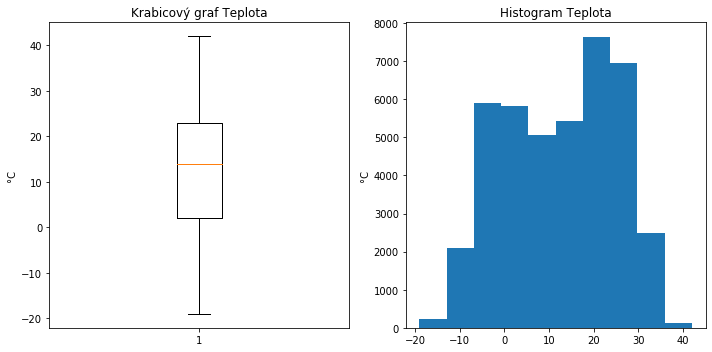

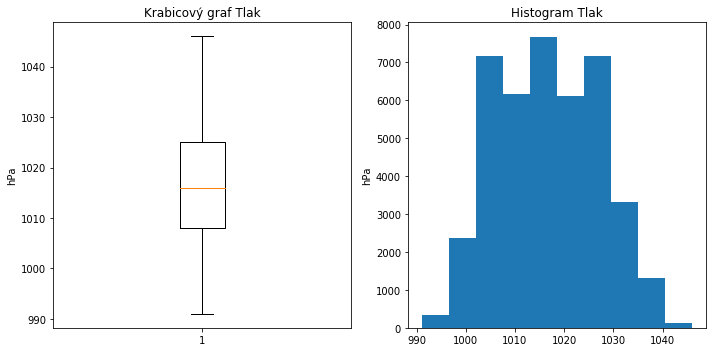

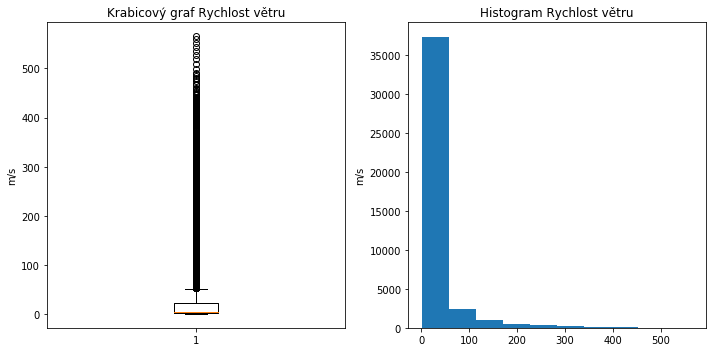

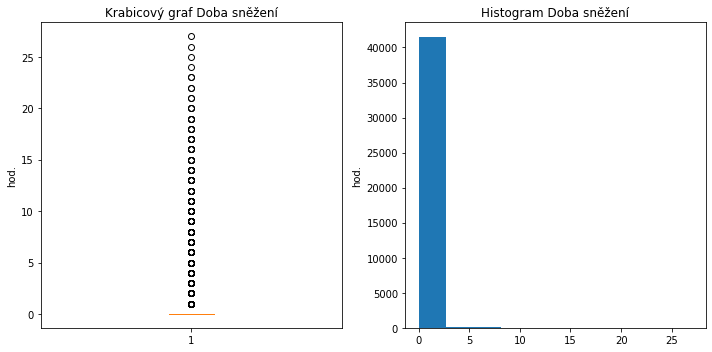

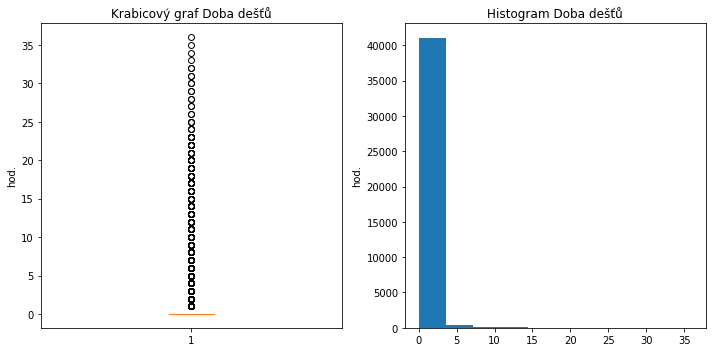

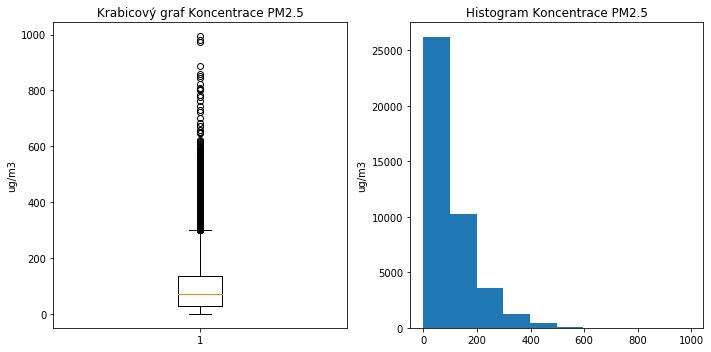

In [22]:
# Histogram / Box plot outlier analysis

names = ["Rosný bod", "Teplota", "Tlak", "Rychlost větru", "Doba sněžení", "Doba dešťů", "Koncentrace PM2.5"]
units =  [ "°C", "°C", "hPa", "m/s", "hod.", "hod.", "ug/m3" ]
pdfFiles = ["dewpt.pdf","temp.pdf","press.pdf","wndspd.pdf","hsnow.pdf","hrain.pdf","pm25.pdf"]
index=0
for c in ["dew_point", "temperature", "pressure", 
          "wind_speed", "hours_snow", "hours_rain", 
          "pm2.5" ]:
    
    data = df[c]
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.title("Krabicový graf " + names[index])
    plt.ylabel(units[index])
    boxPlotObject = plt.boxplot(data, showfliers=True)
    
    plt.subplot(1, 2, 2)
    plt.title("Histogram " + names[index])
    plt.ylabel(units[index])
    plt.hist(data)
    
    totalCount = len(data)
    outlierCount = outlier_count(boxPlotObject)
    
    plt.tight_layout()
    #plt.show()
    plt.savefig(pdfFiles[index])
    print(f"{c} outlier count {outlierCount} out of {totalCount}")
    index += 1

In [23]:
def print_outliers(dataFrame, column):
    q1 = dataFrame[column].quantile(0.25)
    q3 = dataFrame[column].quantile(0.75)
    iqr = q3 - q1
    hint = dataFrame[column].between( (q1 - (1.5 * iqr)), (q3 + (1.5 * iqr)) )
    
    return [ x[0] for x in zip(dataFrame[column], hint) if x[1] == False ]

In [24]:
def remove_outliers(dataFrame, columns):
    for column in columns:
        q1 = dataFrame[column].quantile(0.25)
        q3 = dataFrame[column].quantile(0.75)
        iqr = q3 - q1
        hint = dataFrame[column].between( (q1 - (1.5 * iqr)), (q3 + (1.5 * iqr)) )
        
        newColumnValues = [ (x[0] if x[1] else np.NaN ) for x in zip(dataFrame[column], hint) ]
        dataFrame[column] = newColumnValues
        #inCount = len(dataFrame[column][hint])
        #removedCount = len(dataFrame[column]) - inCount
        #print(f"Removing {removedCount} from col: {column}")

In [25]:
before = df.shape
print(f"Shape before {before}")
remove_outliers(df, ["pm2.5"])
df = df.dropna()
removed = before[0] - df.shape[0]
print(f"Removed {removed} rows because of pm2.5 outliers")
print(f"Shape after {df.shape}")

Shape before (41757, 13)
Removed 1773 rows because of pm2.5 outliers
Shape after (39984, 13)


In [26]:
# HERE WE HAVE df WITHOUT pm2.5 outliers
# WE ALSO CREATE df_no_outliers without any outlier
df_no_outliers = df.copy(deep=True)
before = df_no_outliers.shape
print(f"Shape before {before}")
remove_outliers(df_no_outliers,["wind_speed","hours_snow","hours_rain"])
df_no_outliers = df_no_outliers.dropna()
removedCnt = before[0] - df_no_outliers.shape[0]
print(f"Shape after {df_no_outliers.shape}\nRemoved {removedCnt} rows")

Shape before (39984, 13)
Shape after (33512, 13)
Removed 6472 rows


In [27]:
# Final datasets
df_binAll = pd.get_dummies(df, columns=["hour","week_day","day","month","year", "wind_direction"])
df_binAll_gt = df_binAll["pm2.5"].values
df_binAll.drop(columns=["pm2.5"], inplace=True)
assert (df_binAll.shape[0] == len(df_binAll_gt))

df_binNoDay = pd.get_dummies(df.drop(columns=["day"], axis=1), columns=["hour","week_day","month","year", "wind_direction"])
df_binNoDay_gt = df_binNoDay["pm2.5"].values
df_binNoDay.drop(columns=["pm2.5"], inplace=True)
assert (df_binNoDay.shape[0] == len(df_binNoDay_gt))

df_noOut_binNoDay = pd.get_dummies(df_no_outliers.drop(columns=["day"], axis=1), columns=["hour","week_day","month","year", "wind_direction"])
df_noOut_binNoDay_gt = df_noOut_binNoDay["pm2.5"].values
df_noOut_binNoDay.drop(columns=["pm2.5"], inplace=True)
assert (df_noOut_binNoDay.shape[0] == len(df_noOut_binNoDay_gt))

scaler = MinMaxScaler((0.0, 1.0))
df_binAll = pd.DataFrame(scaler.fit_transform(df_binAll))
df_binNoDay = pd.DataFrame(scaler.fit_transform(df_binNoDay))
df_noOut_binNoDay = pd.DataFrame(scaler.fit_transform(df_noOut_binNoDay))

df_noOut_binNoDay_20attr = pd.DataFrame(PCA(n_components=20).fit_transform(df_noOut_binNoDay))
assert (df_noOut_binNoDay_20attr.shape[0] == len(df_noOut_binNoDay_gt))
assert (df_noOut_binNoDay_20attr.shape[1] == 20)

df_noOut_binNoDay_10attr = pd.DataFrame(PCA(n_components=10).fit_transform(df_noOut_binNoDay))
assert (df_noOut_binNoDay_10attr.shape[0] == len(df_noOut_binNoDay_gt))
assert (df_noOut_binNoDay_10attr.shape[1] == 10)

In [28]:
print("Final datasets")
print(f"    df_binAll\t\t{df_binAll.shape} - all date/times columns binarization, no pm2.5 outliers")
print(f"    df_binNoDay\t\t{df_binNoDay.shape} - removed day column, rest of date/times columns binarization, no pm2.5 outliers")
print(f"    df_noOut_binNoDay\t{df_noOut_binNoDay.shape} - removed day column, date/times binarization, all outliers removed")
print(f"    df_noOut_binNoDay_20attr\t{df_noOut_binNoDay_20attr.shape} - 20 attributes (PCA), removed day column, date/times bin, all outls removed")
print(f"    df_noOut_binNoDay_10attr\t{df_noOut_binNoDay_10attr.shape} - 10 attributes (PCA), removed day column, date/times bin, all outls removed")

Final datasets
    df_binAll		(39984, 89) - all date/times columns binarization, no pm2.5 outliers
    df_binNoDay		(39984, 58) - removed day column, rest of date/times columns binarization, no pm2.5 outliers
    df_noOut_binNoDay	(33512, 58) - removed day column, date/times binarization, all outliers removed
    df_noOut_binNoDay_20attr	(33512, 20) - 20 attributes (PCA), removed day column, date/times bin, all outls removed
    df_noOut_binNoDay_10attr	(33512, 10) - 10 attributes (PCA), removed day column, date/times bin, all outls removed


In [29]:
scorers = { 
    "r2": make_scorer(r2_score), 
    "mae": make_scorer(mean_absolute_error),
    "mse": make_scorer(mean_squared_error),
    "maxe": make_scorer(max_error)
    }
dfs = (("BinAll",df_binAll,df_binAll_gt),
       ("BinAllNoDay",df_binNoDay, df_binNoDay_gt),
       ("BinAllNoDayNoOut",df_noOut_binNoDay,df_noOut_binNoDay_gt),
       ("BinAllNoDayNoOut20Attr",df_noOut_binNoDay_20attr,df_noOut_binNoDay_gt),
       ("BinAllNoDayNoOut10Attr",df_noOut_binNoDay_10attr,df_noOut_binNoDay_gt))

In [30]:
def mean(arr):
    return (sum(arr) / len(arr))

def append_results(results, model, cft, dataFrames, scorers_):
    for name, x, y in dataFrames:
        
        cvScores = cross_validate(cft, x, y, cv = 3, scoring = scorers_)
        
        avgFitTime = mean(cvScores["fit_time"])
        avgScoreTime = mean(cvScores["score_time"])
        bestR2 = mean(cvScores["test_r2"])
        bestMae = mean(cvScores["test_mae"])
        bestMse = mean(cvScores["test_mse"])
        bestMaxE = mean(cvScores["test_maxe"])
        
        result = {"model": model, "name": name,
                  "avg_fit_time": avgFitTime, "avg_score_time": avgScoreTime,
                  "r2": bestR2,
                  "mae": bestMae,
                  "mse": bestMse,
                  "maxE": bestMaxE }
        
        results.append(result)

In [137]:
treeResults = []
# Default
tree = DecisionTreeRegressor()
append_results(treeResults, "default_tree", tree, dfs, scorers)
tree = DecisionTreeRegressor(min_samples_leaf=100)
append_results(treeResults, "min_samples_leaf=100", tree, dfs, scorers)
tree = DecisionTreeRegressor(min_samples_leaf=0.05)
append_results(treeResults, "min_samples_leaf=0.05", tree, dfs, scorers)
tree = DecisionTreeRegressor(min_samples_leaf=200)
append_results(treeResults, "min_samples_leaf=200", tree, dfs, scorers)

In [138]:
treeResults = pd.DataFrame(treeResults)[["model", "name","avg_fit_time","avg_score_time","r2","mse", "mae", "maxE"]]
treeResults.to_csv("regression_tree_results.csv")
treeResults
#df[['mean', '0', '1', '2', '3']]

,model,name,avg_fit_time,avg_score_time,r2,mse,mae,maxE
0,default_tree,BinAll,0.349760,0.025861,-0.357247,6482.516106,57.440926,283.666667
1,default_tree,BinAllNoDay,0.240115,0.020302,-0.379687,6582.024235,57.734719,293.333333
2,default_tree,BinAllNoDayNoOut,0.191849,0.016894,-0.284723,6218.691685,58.045777,288.333333
3,default_tree,BinAllNoDayNoOut20Attr,0.530091,0.010124,-1.223152,10707.720950,80.858597,290.000000
4,default_tree,BinAllNoDayNoOut10Attr,0.266685,0.009440,-1.309076,11109.669544,82.622139,291.333333
5,min_samples_leaf=100,BinAll,0.156808,0.019000,0.180189,3923.627637,46.056886,269.939730
6,min_samples_leaf=100,BinAllNoDay,0.110665,0.013667,0.186880,3887.652602,45.852303,269.939730
7,min_samples_leaf=100,BinAllNoDayNoOut,0.090557,0.009852,0.228097,3734.523553,46.435073,270.433348
8,min_samples_leaf=100,BinAllNoDayNoOut20Attr,0.287711,0.003374,-0.154449,5560.551980,59.117945,266.985567
9,min_samples_leaf=100,BinAllNoDayNoOut10Attr,0.141839,0.007445,-0.126210,5446.543354,57.419837,264.569114


In [ ]:
svrResults = []

svr = SVR(gamma='auto', max_iter=5000)
append_results(svrResults, "svr_max_iter=5000", svr, dfs, scorers)
svr = SVR(gamma='auto', max_iter=5000, C=1000)
append_results(svrResults, "svr_max_iter=5000,C=1000", svr, dfs, scorers)
svr = SVR(gamma='auto', max_iter=10000)
append_results(svrResults, "svr_max_iter=10000", svr, dfs, scorers)

C:\Users\theaz\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\theaz\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\theaz\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\theaz\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\theaz\Anaconda3\lib\site-packag

C:\Users\theaz\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [147]:
svrResults = pd.DataFrame(svrResults)[["model", "name","avg_fit_time","avg_score_time","r2","mse", "mae", "maxE"]]
svrResults.to_csv("svr_results.csv")
svrResults

,model,name,avg_fit_time,avg_score_time,r2,mse,mae,maxE
0,svr_max_iter=2000,BinAll,11.825428,19.452993,-0.044808,5006.398800,60.387022,198.497121
1,svr_max_iter=5000,BinAll,27.803098,48.435108,0.044389,4600.462011,52.682638,231.378865


In [41]:
nnResults = []

#nn = MLPRegressor()
#append_results(nnResults, "default_nn", nn, dfs, scorers)
#nn = MLPRegressor(max_iter=1000)
#append_results(nnResults, "default_nn,max_iter=1000", nn, dfs, scorers)
#nn = MLPRegressor(hidden_layer_sizes=(5,5,5))
#append_results(nnResults, "nn (5,5,5)", nn, dfs, scorers)

nn = MLPRegressor(hidden_layer_sizes=(3,3,3))
append_results(nnResults, "nn (3,3,3)", nn, dfs, scorers)
nn = MLPRegressor(hidden_layer_sizes=(5,5,5,3))
append_results(nnResults, "nn (5,5,5,3)", nn, dfs, scorers)
#nn = MLPRegressor(hidden_layer_sizes=(30,30,30))
#append_results(nnResults, "nn (30,30,30)", nn, dfs, scorers)
#nn = MLPRegressor(hidden_layer_sizes=(30,50,40,30,20))
#append_results(nnResults, "nn (30,50,40,30,20)", nn, dfs, scorers)

#nn = MLPRegressor(hidden_layer_sizes=(30,30,30),max_iter=1000)
#append_results(nnResults, "nn (30,30,30),max_iter=1000", nn, dfs, scorers)

C:\Users\theaz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theaz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theaz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theaz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

In [43]:
nnResults = pd.DataFrame(nnResults)[["model", "name","avg_fit_time","avg_score_time","r2","mse", "mae", "maxE"]]
nnResults.to_csv("nn_results3.csv")
nnResults

,model,name,avg_fit_time,avg_score_time,r2,mse,mae,maxE
0,"nn (3,3,3)",BinAll,12.959080,0.010405,-0.032243,5155.360470,50.886845,266.542614
1,"nn (3,3,3)",BinAllNoDay,13.497434,0.005211,-0.098796,5459.879418,53.677045,268.692192
2,"nn (3,3,3)",BinAllNoDayNoOut,11.233080,0.010407,0.309848,3340.015594,44.655279,257.463995
3,"nn (3,3,3)",BinAllNoDayNoOut20Attr,9.028628,0.010416,-0.664403,8112.431734,67.221256,280.034286
4,"nn (3,3,3)",BinAllNoDayNoOut10Attr,4.760656,0.010417,-0.071780,5205.401488,56.695336,226.523752
5,"nn (5,5,5,3)",BinAll,18.662693,0.020844,-0.107247,5217.485209,56.774270,292.359978
6,"nn (5,5,5,3)",BinAllNoDay,18.181027,0.020845,-0.262583,6151.575300,57.747337,278.202601
7,"nn (5,5,5,3)",BinAllNoDayNoOut,14.457640,0.015631,0.165456,4018.866990,49.801066,253.517416
8,"nn (5,5,5,3)",BinAllNoDayNoOut20Attr,13.019090,0.010420,-0.554191,7441.424973,64.352230,277.916211
9,"nn (5,5,5,3)",BinAllNoDayNoOut10Attr,12.562943,0.015626,-0.300400,6225.932173,60.884040,270.145720


In [31]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

In [43]:
gbrResult = []
gbr = GradientBoostingRegressor(min_samples_leaf=100)
append_results(gbrResult, "GBR min_samples_leaf=100", gbr, dfs, scorers)
gbr = GradientBoostingRegressor(min_samples_leaf=200)
append_results(gbrResult, "GBR min_samples_leaf=200", gbr, dfs, scorers)

[{'model': 'GBR min_samples_leaf=200,n_estimators=150',
  'name': 'BinAll',
  'avg_fit_time': 5.14162031809489,
  'avg_score_time': 0.09335660934448242,
  'r2': 0.3654866076838401,
  'mae': 42.05486423918353,
  'mse': 3043.109421103222,
  'maxE': 254.91659210227957},
 {'model': 'GBR min_samples_leaf=200,n_estimators=150',
  'name': 'BinAllNoDay',
  'avg_fit_time': 3.6184967358907065,
  'avg_score_time': 0.0770107905069987,
  'r2': 0.3669321480952899,
  'mae': 41.93600517865184,
  'mse': 3033.2793042909775,
  'maxE': 257.85867896139285},
 {'model': 'GBR min_samples_leaf=200,n_estimators=150',
  'name': 'BinAllNoDayNoOut',
  'avg_fit_time': 2.7934743563334146,
  'avg_score_time': 0.06470092137654622,
  'r2': 0.34016151889906293,
  'mae': 44.17048970665337,
  'mse': 3188.8604039472625,
  'maxE': 254.9076736158112},
 {'model': 'GBR min_samples_leaf=200,n_estimators=150',
  'name': 'BinAllNoDayNoOut20Attr',
  'avg_fit_time': 3.617800315221151,
  'avg_score_time': 0.05567765235900879,
  'r2'

In [42]:
gbrResult = pd.DataFrame(gbrResult)[["model", "name","avg_fit_time","avg_score_time","r2","mse", "mae", "maxE"]]
gbrResult.to_csv("gbrResult.csv")
gbrResult

,model,name,avg_fit_time,avg_score_time,r2,mse,mae,maxE
0,GBR min_samples_leaf=100,BinAll,3.607578,0.071423,0.340214,3168.040854,43.053913,250.205400
1,GBR min_samples_leaf=100,BinAllNoDay,2.437063,0.065346,0.339260,3170.590554,42.980285,252.932608
2,GBR min_samples_leaf=100,BinAllNoDayNoOut,2.002687,0.050321,0.328272,3248.267659,44.693436,251.206695
3,GBR min_samples_leaf=100,BinAllNoDayNoOut20Attr,2.489593,0.039349,0.036543,4655.071327,54.810862,254.072118
4,GBR min_samples_leaf=100,BinAllNoDayNoOut10Attr,1.306492,0.036200,0.017166,4754.767708,55.770490,246.952627
5,GBR min_samples_leaf=200,BinAll,3.685808,0.090837,0.348144,3128.816527,42.805841,252.618783
6,GBR min_samples_leaf=200,BinAllNoDay,2.576097,0.060016,0.352602,3104.647146,42.606725,255.306238
7,GBR min_samples_leaf=200,BinAllNoDayNoOut,2.061314,0.051650,0.321381,3280.466748,44.981824,250.167177
8,GBR min_samples_leaf=200,BinAllNoDayNoOut20Attr,2.482072,0.039658,0.038456,4645.495471,55.181721,247.440418
9,GBR min_samples_leaf=200,BinAllNoDayNoOut10Attr,1.280082,0.037664,0.021367,4733.655868,55.805436,244.561871


In [45]:
rfrResults = []
rfr = RandomForestRegressor(n_estimators=100)
append_results(rfrResults, "RFR n_estimators=100", rfr, dfs, scorers)
pd.DataFrame(rfrResults)

,avg_fit_time,avg_score_time,mae,maxE,model,mse,name,r2
0,22.922560,0.845106,43.258009,265.783333,RFR n_estimators=100,3533.601631,BinAll,0.260423
1,15.467645,0.767792,43.718419,265.933333,RFR n_estimators=100,3618.714805,BinAllNoDay,0.241892
2,12.429064,0.648804,44.541544,263.126667,RFR n_estimators=100,3471.420042,BinAllNoDayNoOut,0.281835
3,32.457592,0.463171,58.577493,250.630000,RFR n_estimators=100,5043.728305,BinAllNoDayNoOut20Attr,-0.046174
4,16.514818,0.384509,63.066971,254.240000,RFR n_estimators=100,5810.074264,BinAllNoDayNoOut10Attr,-0.204187


In [46]:
rfrResults = pd.DataFrame(rfrResults)[["model", "name","avg_fit_time","avg_score_time","r2","mse", "mae", "maxE"]]
rfrResults.to_csv("rfrResults.csv")
rfrResults

,model,name,avg_fit_time,avg_score_time,r2,mse,mae,maxE
0,RFR n_estimators=100,BinAll,22.922560,0.845106,0.260423,3533.601631,43.258009,265.783333
1,RFR n_estimators=100,BinAllNoDay,15.467645,0.767792,0.241892,3618.714805,43.718419,265.933333
2,RFR n_estimators=100,BinAllNoDayNoOut,12.429064,0.648804,0.281835,3471.420042,44.541544,263.126667
3,RFR n_estimators=100,BinAllNoDayNoOut20Attr,32.457592,0.463171,-0.046174,5043.728305,58.577493,250.630000
4,RFR n_estimators=100,BinAllNoDayNoOut10Attr,16.514818,0.384509,-0.204187,5810.074264,63.066971,254.240000


In [50]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
hgbrResult = []
hgbr = HistGradientBoostingRegressor(min_samples_leaf=100)
append_results(hgbrResult, "GBR min_samples_leaf=100", hgbr, dfs, scorers)
hgbr = HistGradientBoostingRegressor(min_samples_leaf=200)
append_results(hgbrResult, "GBR min_samples_leaf=200", hgbr, dfs, scorers)
hgbr = HistGradientBoostingRegressor(min_samples_leaf=200, max_iter=150)
append_results(hgbrResult, "GBR min_samples_leaf=200, max_iter=150", hgbr, dfs, scorers)

In [51]:
hgbrResult = pd.DataFrame(hgbrResult)[["model", "name","avg_fit_time","avg_score_time","r2","mse", "mae", "maxE"]]
hgbrResult.to_csv("hgbrResult.csv")
hgbrResult

,model,name,avg_fit_time,avg_score_time,r2,mse,mae,maxE
0,GBR min_samples_leaf=100,BinAll,4.411994,0.073667,0.357294,3075.099101,41.278394,260.161705
1,GBR min_samples_leaf=100,BinAllNoDay,2.881667,0.068760,0.356886,3072.140008,40.895252,262.207775
2,GBR min_samples_leaf=100,BinAllNoDayNoOut,2.767208,0.062500,0.357275,3102.075067,42.569569,258.031647
3,GBR min_samples_leaf=100,BinAllNoDayNoOut20Attr,1.657222,0.068000,0.025927,4699.719388,54.938946,252.412494
4,GBR min_samples_leaf=100,BinAllNoDayNoOut10Attr,1.304387,0.083334,-0.080976,5221.072427,59.270617,247.854763
5,GBR min_samples_leaf=200,BinAll,4.642172,0.103761,0.361527,3054.842308,41.174054,253.323265
6,GBR min_samples_leaf=200,BinAllNoDay,3.142123,0.102998,0.370378,3011.834741,40.635416,257.503112
7,GBR min_samples_leaf=200,BinAllNoDayNoOut,3.022390,0.076969,0.352920,3122.837544,42.872056,255.828352
8,GBR min_samples_leaf=200,BinAllNoDayNoOut20Attr,1.705363,0.068648,0.039903,4631.964585,54.758546,253.568500
9,GBR min_samples_leaf=200,BinAllNoDayNoOut10Attr,1.353872,0.069674,-0.053835,5087.788590,58.126207,261.977785


In [54]:
from sklearn.ensemble import AdaBoostRegressor

abrResults = []
abr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(min_samples_leaf=100))
append_results(abrResults, "ABR min_samples_leaf=100", abr, dfs, scorers)
abr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(min_samples_leaf=200))
append_results(abrResults, "ABR min_samples_leaf=200", abr, dfs, scorers)

In [56]:
abrResults = pd.DataFrame(abrResults)[["model", "name","avg_fit_time","avg_score_time","r2","mse", "mae", "maxE"]]
abrResults.to_csv("abrResults.csv")
abrResults

,model,name,avg_fit_time,avg_score_time,r2,mse,mae,maxE
0,ABR min_samples_leaf=100,BinAll,15.069673,1.043897,0.317054,3266.215067,46.209882,236.935852
1,ABR min_samples_leaf=100,BinAllNoDay,8.875480,0.715335,0.305942,3318.761039,46.924748,235.875835
2,ABR min_samples_leaf=100,BinAllNoDayNoOut,6.928625,0.665558,0.274502,3502.603445,48.681670,232.984008
3,ABR min_samples_leaf=100,BinAllNoDayNoOut20Attr,14.693060,0.269634,-0.068451,5160.132717,60.461221,229.450034
4,ABR min_samples_leaf=100,BinAllNoDayNoOut10Attr,8.954566,0.247424,-0.188373,5718.199567,63.982144,215.253320
5,ABR min_samples_leaf=200,BinAll,16.876214,1.033265,0.270466,3492.113430,49.506774,227.435554
6,ABR min_samples_leaf=200,BinAllNoDay,7.863186,0.678283,0.238922,3639.555436,50.824106,221.942506
7,ABR min_samples_leaf=200,BinAllNoDayNoOut,5.831003,0.559789,0.217095,3782.324832,51.922815,222.227873
8,ABR min_samples_leaf=200,BinAllNoDayNoOut20Attr,12.224130,0.246564,-0.093629,5278.624393,61.816350,217.010710
9,ABR min_samples_leaf=200,BinAllNoDayNoOut10Attr,7.458305,0.213020,-0.175723,5676.467995,64.509832,211.431327


In [ ]:
abnnResults = []
nn = MLPRegressor(hidden_layer_sizes=(5,5,5))
abrNN = AdaBoostRegressor(base_estimator=nn)
append_results(abnnResults, "ABR min_samples_leaf=100", abrNN, dfs, scorers)
pd.DataFrame(abnnResults)

C:\Users\theaz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theaz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theaz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theaz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge